# Predicting Altruism Through Free Pizza

Used MongoDB to load the JSON files obtained from our [Kaggle dataset](https://www.kaggle.com/kaggle/random-acts-of-pizza).

In [1]:
from pymongo import MongoClient
import pandas as pd
import numpy as np
from tqdm import tqdm

In [2]:
client = MongoClient()

In [3]:
db = client.pizza

In [4]:
db.list_collection_names()

['test', 'train']

In [5]:
list(db.train.find().limit(1))

[{'_id': ObjectId('5f31f2c2c0236f72a131a3aa'),
  'giver_username_if_known': 'N/A',
  'number_of_downvotes_of_request_at_retrieval': 1,
  'number_of_upvotes_of_request_at_retrieval': 2,
  'post_was_edited': 1342028318.0,
  'request_id': 't3_wcw5m',
  'request_number_of_comments_at_retrieval': 3,
  'request_text': "We're in Tampa Florida...moving to Ybor on Friday. My email is usfstuff@yahoo.com, since I'm having major trouble figuring out reddit's message system.\n\n\nMy two roommates and I have found a new place to live and are moving in on Friday. The rent is $1100 including utitilies and internet. My 2 roomies have very nicely offered for me to just pay $200 a month until I have a job. I am so thankful to have them as friends! This month all of us are extremely poor from paying $2000 to landlord (first+last rent+deposit). We also had to pay $310 for TECO to turn on the electricity.\n\n\nI would just really love to do something nice for them and pick them up a pizza and a sub/pzone. M

In [6]:
db.train.count_documents({})

4040

In [7]:
cursor = db.train.find({}, {'_id': 0, 'request_title': 1, 'request_text': 1})
list(cursor)[0]


{'request_text': "We're in Tampa Florida...moving to Ybor on Friday. My email is usfstuff@yahoo.com, since I'm having major trouble figuring out reddit's message system.\n\n\nMy two roommates and I have found a new place to live and are moving in on Friday. The rent is $1100 including utitilies and internet. My 2 roomies have very nicely offered for me to just pay $200 a month until I have a job. I am so thankful to have them as friends! This month all of us are extremely poor from paying $2000 to landlord (first+last rent+deposit). We also had to pay $310 for TECO to turn on the electricity.\n\n\nI would just really love to do something nice for them and pick them up a pizza and a sub/pzone. My one roomie doesn't love pizza and she only ever gets a sub/pzone haha. Using a few coupons, I can get 8 pizza rollers, 1 large pizza, and a pzone for $11 from Pizza Hut. If anyone can help me out I would be so grateful! Pizza Hut is just the cheapest, if you have something else in mind let me k

# Combining Kaggle and API-Pulled Submissions to Construct Training and Testing Dataframes.

Extracted out needed values for a training and testing dataframe.

In [8]:
# Training
cursor = db.train.find({}, {'_id': 0, 'request_title': 1, 'request_text': 1, 'requester_received_pizza': 1,
                            'unix_timestamp_of_request_utc': 1})

requests_list = []
received_pizza = []
timestamp = []

for each in list(cursor):
#     for items in each:
    requests_list.append(each['request_title'] + ' ' + each['request_text'])
    received_pizza.append(each['requester_received_pizza'])
    timestamp.append(each['unix_timestamp_of_request_utc'])

In [9]:
# Testing
# Testing does not have flairs, so we'll have to manually pull that in with submission ids.
cursor2 = db.test.find({}, {'_id': 0, 'request_title': 1, 'request_text_edit_aware': 1, 'request_id': 1,
                            'unix_timestamp_of_request_utc': 1})
requests_list2 = []
submissionids = []
timestamp2 = []

for each in list(cursor2):
    requests_list2.append(each['request_title'] + ' ' + each['request_text_edit_aware'])
    submissionids.append(each['request_id'])
    timestamp2.append(each['unix_timestamp_of_request_utc'])

In [10]:
len(submissionids)

1631

We will construct dataframes for both the training and testing datasets.

In [11]:
import pandas as pd

pizza_training = pd.DataFrame({'request_text': [], 'received_pizza': []})
pizza_testing = pd.DataFrame({'request_text': [], 'submissionids': []})

In [12]:
# Adding in the values for each columns.
pizza_training['request_text'] = requests_list
pizza_training['received_pizza'] = received_pizza
pizza_training['unix_timestamp_of_request_utc'] = timestamp

pizza_testing['request_text'] = requests_list2
pizza_testing['submissionids'] = submissionids
pizza_testing['unix_timestamp_of_request_utc'] = timestamp2

In [13]:
# Let's convert the UTC time to a general time we can interpret.
import datetime

pizza_training['unix_timestamp_of_request_utc'] = pizza_training['unix_timestamp_of_request_utc'].astype(int)
pizza_training['unix_timestamp_of_request_utc'] = pizza_training['unix_timestamp_of_request_utc'].apply(lambda x: datetime.datetime.utcfromtimestamp(x))


pizza_testing['unix_timestamp_of_request_utc'] = pizza_testing['unix_timestamp_of_request_utc'].astype(int)
pizza_testing['unix_timestamp_of_request_utc'] = pizza_testing['unix_timestamp_of_request_utc'].apply(lambda x: datetime.datetime.utcfromtimestamp(x))

In [14]:
pizza_training.head()

,request_text,received_pizza,unix_timestamp_of_request_utc
0,[Request] Help me give back to my roomies on F...,False,2012-07-11 00:21:35
1,Request Colorado Springs Help Us Please Hi I a...,False,2011-10-05 21:10:07
2,"[Request] Hungry couple in Dundee, Scotland wo...",False,2011-10-26 16:28:14
3,"[Request] In Canada (Ontario), just got home f...",False,2011-12-02 19:50:34
4,"[Request] California, No cash and I could use ...",False,2012-03-25 04:13:44


In [15]:
pizza_testing.head()

,request_text,submissionids,unix_timestamp_of_request_utc
0,[request] pregger gf 95 degree house and no fo...,t3_i8iy4,2011-06-24 23:56:59
1,"[Request] Lost my job day after labour day, st...",t3_1mfqi0,2013-09-15 15:45:23
2,[Request] Just moved to a new state(Waltham MA...,t3_1jdgdj,2013-07-30 20:38:02
3,(Request) pizza for my kids please? Hi Reddit....,t3_lclka,2011-10-14 22:53:41
4,"[Request] Two girls in between paychecks, we'v...",t3_t2qt4,2012-05-02 03:52:38


In [16]:
pizza_testing['submissionids'] = pizza_testing['submissionids'].apply(lambda x: x.replace('t3_', ''))

In [17]:
pizza_testing.to_csv('kaggle_pizza_test.csv', index = False)

Using PRAW API, I was able to grab all the associated link flairs for each test dataset. All of the posts had no flair though, resulting in False for all of them. 

In [18]:
pizza_testing = pd.read_csv('kaggle_pizza_test_final.csv')

In [19]:
pizza_testing = pizza_testing[['request_text', 'unix_timestamp_of_request_utc', 'received_pizza']]

The post submissions in the Kaggle dataset ranged from December 8, 2010 through September 29, 2013. Using a combination of the PRAW and PushShiftData API, I was able to pull 32,980 submissions from January 1, 2014 - August 14, 2020. 

We will add the pulled submissions to the dataframes.

In [20]:
api_pizza_submissions = pd.read_csv('final_clean2.csv')

In [21]:
api_pizza_submissions

,request_text,received_pizza,unix_timestamp_of_request_utc
0,Im Hungry on nye [Request] I'm a lonely loner ...,False,12/31/13 19:25
1,"[request] Just another alone on NYE, sick of b...",False,12/31/13 19:35
2,"[request] Today is also my birthday, spending ...",False,12/31/13 19:37
3,[Request] Alone and sick on NYE.. could use a ...,False,12/31/13 19:54
4,"[REQUEST] home, alone, broke, and hungry Broke...",False,12/31/13 19:55
...,...,...,...
32977,[REQUEST] been feeling depressed and could use...,False,8/13/20 12:14
32978,[Request] Finally had what feels like a good j...,False,8/13/20 12:35
32979,"[Request] it’s been a long two weeks, my accou...",False,8/13/20 14:24
32980,[request] I got invited to a friend and want t...,False,8/13/20 14:29


In [22]:
api_pizza_submissions[api_pizza_submissions.duplicated()]

,request_text,received_pizza,unix_timestamp_of_request_utc
11889,"[Request] Job hunting, don't know what I'm doi...",False,12/14/15 23:37
11890,"[Request] Job hunting, don't know what I'm doi...",False,12/14/15 23:37
11891,"[Request] Job hunting, don't know what I'm doi...",False,12/14/15 23:37
11892,"[Request] Job hunting, don't know what I'm doi...",False,12/14/15 23:37
11893,"[Request] Job hunting, don't know what I'm doi...",False,12/14/15 23:37
32744,[REQUEST] Just need a pizza to tide me over ti...,False,7/16/20 22:46


In [23]:
api_pizza_submissions = api_pizza_submissions.drop_duplicates()

In [24]:
api_pizza_submissions

,request_text,received_pizza,unix_timestamp_of_request_utc
0,Im Hungry on nye [Request] I'm a lonely loner ...,False,12/31/13 19:25
1,"[request] Just another alone on NYE, sick of b...",False,12/31/13 19:35
2,"[request] Today is also my birthday, spending ...",False,12/31/13 19:37
3,[Request] Alone and sick on NYE.. could use a ...,False,12/31/13 19:54
4,"[REQUEST] home, alone, broke, and hungry Broke...",False,12/31/13 19:55
...,...,...,...
32977,[REQUEST] been feeling depressed and could use...,False,8/13/20 12:14
32978,[Request] Finally had what feels like a good j...,False,8/13/20 12:35
32979,"[Request] it’s been a long two weeks, my accou...",False,8/13/20 14:24
32980,[request] I got invited to a friend and want t...,False,8/13/20 14:29


In [25]:
api_pizza_submissions_shuffled = api_pizza_submissions.sample(frac = 1)

We will split the API-pulled submissions into training and testing by a 80-20 ratio, respectively.

In [26]:
training_pizza = api_pizza_submissions_shuffled.iloc[:26380]

In [27]:
testing_pizza = api_pizza_submissions_shuffled.iloc[26380:]

I will construct one dataframe to hold all training data and another dataframe to hold all of testing data.

In [28]:
combo_pizza_training = pd.concat([pizza_training, training_pizza])

combo_pizza_training.reset_index(inplace = True)

combo_pizza_training.drop('index', axis = 1, inplace = True)

In [29]:
combo_pizza_training

,request_text,received_pizza,unix_timestamp_of_request_utc
0,[Request] Help me give back to my roomies on F...,False,2012-07-11 00:21:35
1,Request Colorado Springs Help Us Please Hi I a...,False,2011-10-05 21:10:07
2,"[Request] Hungry couple in Dundee, Scotland wo...",False,2011-10-26 16:28:14
3,"[Request] In Canada (Ontario), just got home f...",False,2011-12-02 19:50:34
4,"[Request] California, No cash and I could use ...",False,2012-03-25 04:13:44
...,...,...,...
30415,[Request]Just got denied financial aid for col...,True,4/16/19 19:51
30416,"[Request] Broke and struggling, pls respond. H...",False,1/11/14 12:05
30417,[Request] No desire to cook after a garbage da...,False,8/8/19 21:26
30418,[REQUEST] Hey there - I’m on week 7 of camping...,True,8/21/19 20:02


In [30]:
combo_pizza_testing = pd.concat([pizza_testing, testing_pizza])

combo_pizza_testing.reset_index(inplace = True)

combo_pizza_testing.drop('index', axis = 1, inplace = True)

In [31]:
combo_pizza_testing

,request_text,unix_timestamp_of_request_utc,received_pizza
0,[request] pregger gf 95 degree house and no fo...,2011-06-24 23:56:59,False
1,"[Request] Lost my job day after labour day, st...",2013-09-15 15:45:23,False
2,[Request] Just moved to a new state(Waltham MA...,2013-07-30 20:38:02,False
3,(Request) pizza for my kids please? Hi Reddit....,2011-10-14 22:53:41,False
4,"[Request] Two girls in between paychecks, we'v...",2012-05-02 03:52:38,False
...,...,...,...
8222,"[Request] My first day of vacation, would like...",11/22/16 10:58,False
8223,[REQUEST] My boyfriend and I would love someth...,6/29/15 14:21,False
8224,"[REQUEST] Broke and hungry, would love some pi...",9/29/19 18:54,False
8225,[Request] A Pizza for a Toy store girl who doe...,9/30/14 23:01,False


## Cleaning the Text

Let's go ahead and clean the requests by making the text lowercase, removing stop-words, removing punctuation, numbers, and other nonsensical text.

We will be using *spaCy* to parse out the request_text.

In [32]:
import spacy
import en_core_web_sm
from spacy.lang.en.stop_words import STOP_WORDS

In [33]:
nlp = spacy.load('en_core_web_sm')

In [34]:
# These are pizza submission requests - we don't need these.

new_stop_words = ['request', 'pizza', 'like', 'day', 'time','today', 'month', 'week', 'thing', 'try', 'want', 'know', 'feel', 'find',
                  'come', 'hut', 'thank', 'papa', 'dominos', 'near', 'place', 'right', 'johns', 'like', 'eat', 'forward', 'new', 'able',
                  'live', 'break', 'ask', 'little', 'post', 'think', 'use', 'way', 'tonight', 'tomorrow', 'thursday', 'monday', 'buy',
                  'night', 'year', 'guy', 'shift', 'ago', 'finally', 'long', 'currently', 'hey', 'willing', 'kind', 'soon', 'look', 'wait',
                  'run', 'cat', 'leave', 'need', 'bad', 'good', 'end', 'lot', 'sure', 'nice', 'tell', 'pick', 'recently', 'edit', 'read', 'reddit',
                  'domino', 'apply', 'greatly', 'past', 'wednesday', 'definitely', 'gladly', 'foot', 'til', 'pretty', 'till', 'friday', 'hour',
                  'great', 'tuesday', 'title', 'super', 'uk', 'pie', 'hi', 'food', 'send', 'help', 'appreciate', 'bit', 'close', 'chain', 'return',
                  'hope', 'favor', 'usa', 'draw', 'moment', 'kinda', 'girl', 'order', 'howie', 'stick', 'hard', 'lay', 'luck', 'offer', 'life',
                  'promise', 'weekend', 'happy', 'dollar', 'sad', 'amp', 'canada', 'literally', 'dude', 'awesome', 'hot', 'cheesy', 'hold', 'area',
                  'advance', 'happy', 'cheese', 'share', 'noodle', 'gift', 'figure', 'australia', 'sub', 'bored', 'extremely', 'hell', 'sit', 'real',
                  'hello', 'cool', 'short', 'flat', 'john', 'dog', 'picture', 'afford', 'meal', 'rooomate', 'feed', 'pepperoni', 'story', 'tired',
                  'poor', 'nearby']

for each in new_stop_words:
    STOP_WORDS.add(each)

hungry, love, broke, payday, story, sob, raman, starve, sick, tired, unemployed, couple, delicious, roommate, cash, dinner, house, celebrate, poor, nearby

In [35]:
def lemmatize_pipe(doc):
    lemma_list = [token.lemma_.lower() for token in doc if token.is_alpha and token.text.lower() not in STOP_WORDS]
    lemma_list2 = [token for token in lemma_list if token not in STOP_WORDS]
    return lemma_list2

In [36]:
def preprocess_pipe(texts):
    preproc_pipe = []
    for doc in nlp.pipe(texts):
        preproc_pipe.append(lemmatize_pipe(doc))
    return preproc_pipe

In [37]:
combo_pizza_training['filtered_text'] = preprocess_pipe(tqdm(combo_pizza_training['request_text']))

100%|██████████| 30420/30420 [04:28<00:00, 113.34it/s]


In [38]:
combo_pizza_testing['filtered_text'] = preprocess_pipe(tqdm(combo_pizza_testing['request_text']))

100%|██████████| 8227/8227 [01:11<00:00, 114.36it/s]


In [39]:
combo_pizza_training.head()

,request_text,received_pizza,unix_timestamp_of_request_utc,filtered_text
0,[Request] Help me give back to my roomies on F...,False,2012-07-11 00:21:35,"[roomie, tampa, florida, ybor, email, major, t..."
1,Request Colorado Springs Help Us Please Hi I a...,False,2011-10-05 21:10:07,"[colorado, springs, child, military, family, h..."
2,"[Request] Hungry couple in Dundee, Scotland wo...",False,2011-10-26 16:28:14,"[hungry, couple, dundee, scotland, love, girlf..."
3,"[Request] In Canada (Ontario), just got home f...",False,2011-12-02 19:50:34,"[ontario, home, school, cold, hungry, complete..."
4,"[Request] California, No cash and I could use ...",False,2012-03-25 04:13:44,"[california, cash, dinner, spend, money, gas]"


Here, we will be removing stop words by importing STOP_WORDS and also adding 'request' and 'pizza' to the STOP_WORDS vocabulary, since those terms are common throughout each request title and body.

In [40]:
combo_pizza_training.head()

,request_text,received_pizza,unix_timestamp_of_request_utc,filtered_text
0,[Request] Help me give back to my roomies on F...,False,2012-07-11 00:21:35,"[roomie, tampa, florida, ybor, email, major, t..."
1,Request Colorado Springs Help Us Please Hi I a...,False,2011-10-05 21:10:07,"[colorado, springs, child, military, family, h..."
2,"[Request] Hungry couple in Dundee, Scotland wo...",False,2011-10-26 16:28:14,"[hungry, couple, dundee, scotland, love, girlf..."
3,"[Request] In Canada (Ontario), just got home f...",False,2011-12-02 19:50:34,"[ontario, home, school, cold, hungry, complete..."
4,"[Request] California, No cash and I could use ...",False,2012-03-25 04:13:44,"[california, cash, dinner, spend, money, gas]"


In [41]:
def convert_list(org_list, seperator = ','):
    return seperator.join(org_list)

In [42]:
combo_pizza_training['filtered_text'] = combo_pizza_training['filtered_text'].apply(convert_list)

combo_pizza_testing['filtered_text'] = combo_pizza_testing['filtered_text'].apply(convert_list)

In [43]:
combo_pizza_training['filtered_text'] = combo_pizza_training['filtered_text'].apply(lambda x: x.replace(',', ' '))

combo_pizza_testing['filtered_text'] = combo_pizza_testing['filtered_text'].apply(lambda x: x.replace(',', ' '))

In [44]:
combo_pizza_training.head()

,request_text,received_pizza,unix_timestamp_of_request_utc,filtered_text
0,[Request] Help me give back to my roomies on F...,False,2012-07-11 00:21:35,roomie tampa florida ybor email major trouble ...
1,Request Colorado Springs Help Us Please Hi I a...,False,2011-10-05 21:10:07,colorado springs child military family hit exa...
2,"[Request] Hungry couple in Dundee, Scotland wo...",False,2011-10-26 16:28:14,hungry couple dundee scotland love girlfriend ...
3,"[Request] In Canada (Ontario), just got home f...",False,2011-12-02 19:50:34,ontario home school cold hungry completely hon...
4,"[Request] California, No cash and I could use ...",False,2012-03-25 04:13:44,california cash dinner spend money gas


In [45]:
combo_pizza_testing.head()

,request_text,unix_timestamp_of_request_utc,received_pizza,filtered_text
0,[request] pregger gf 95 degree house and no fo...,2011-06-24 23:56:59,False,pregger gf degree house pay northern colorado ...
1,"[Request] Lost my job day after labour day, st...",2013-09-15 15:45:23,False,lose job labour start job pay oct exist sick l...
2,[Request] Just moved to a new state(Waltham MA...,2013-07-30 20:38:02,False,ma comfort waltham ma home state pa comfort lo...
3,(Request) pizza for my kids please? Hi Reddit....,2011-10-14 22:53:41,False,kid single dad rough friend mention site work ...
4,"[Request] Two girls in between paychecks, we'v...",2012-05-02 03:52:38,False,paycheck indianapolis wish poptart pull double...


## Simple EDA - Class Imbalance

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

%matplotlib inline

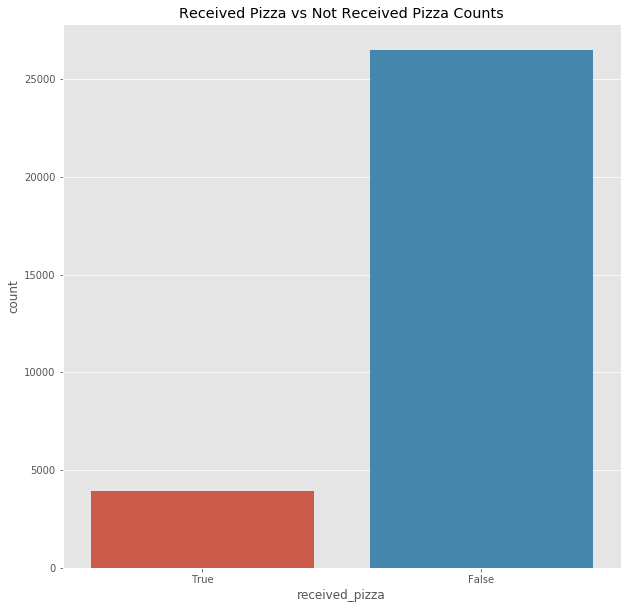

In [47]:
fig = plt.figure(figsize = (10,10))
plt.title('Received Pizza vs Not Received Pizza Counts')
sns.countplot(combo_pizza_training['received_pizza'], order = [True, False])

In [209]:
combo_pizza_training['received_pizza'].value_counts()

False    26493
True      3927
Name: received_pizza, dtype: int64

## Count Vectorizer - Entire Training Dataset (for Classification)

In [48]:
from sklearn.feature_extraction.text import CountVectorizer

In [49]:
cv_training = CountVectorizer(stop_words = 'english', min_df = 5)

In [50]:
pizza_cv_training = cv_training.fit_transform(combo_pizza_training['filtered_text'])

In [51]:
pizza_data = pd.DataFrame(pizza_cv_training.toarray(), columns = cv_training.get_feature_names())

pizza_data

,aa,ab,abandon,abc,ability,abit,abroad,abruptly,abscess,absence,...,zap,zealand,zelda,zero,zip,zipcode,zombie,zone,zoo,zza
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30415,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
30416,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30417,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30418,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
cv_testing = CountVectorizer(stop_words = 'english', min_df = 5)

In [53]:
pizza_cv_testing = cv_testing.fit_transform(combo_pizza_testing['filtered_text'])

In [54]:
pizza_data2 = pd.DataFrame(pizza_cv_testing.toarray(), columns = cv_testing.get_feature_names())

## Count Vectorizer - Received Pizza vs Did Not Receive Pizza (EDA)

Because I am dealing with received pizza submissions vs did not receive pizza posts, it's important to examine the difference of words between the two classifications.

We will create two Count Vectorizers for Received Pizza submissions - one for unigrams only, and the other with a combination of unigrams and bigrams.

In [55]:
received = combo_pizza_training[combo_pizza_training['received_pizza'] == True]

In [56]:
received

,request_text,received_pizza,unix_timestamp_of_request_utc,filtered_text
5,[REQUEST] I'll give a two week xbox live code ...,True,2012-12-07 20:21:40,xbox code slice weather work hate beg payday c
9,[REQUEST]We're in need of some om noms... Aust...,True,2011-08-31 20:59:42,om nom austin texas roommate hungry sort count...
12,[REQUEST] Bummed out in Chicago. Too broke to ...,True,2013-01-19 01:34:46,bum chicago cheer unemployed work odd job work...
15,"[request] Cookeville, TN. My dog recently died...",True,2012-11-25 06:31:33,cookeville tn die cheer family pay later
17,"[Request] Virginia. Girlfriend and I our sick,...",True,2012-09-11 18:41:38,virginia girlfriend sick pay love pay locate v...
...,...,...,...,...
30373,[Request] Family of 3 and a zoo od fur childre...,True,12/1/17 20:31,family zoo od fur child power freshly flood ap...
30391,[request] trying to get the boys dinner It’s b...,True,10/22/18 18:45,boy dinner fall old okay dwindle
30410,"[REQUEST] Broke, tired and the chickens frozen...",True,10/18/18 13:21,broke chicken freeze baby boy spend diaper wip...
30415,[Request]Just got denied financial aid for col...,True,4/16/19 19:51,deny financial aid college absence mental heal...


In [57]:
cv_received_uni = CountVectorizer(min_df = 5)
pizza_cv_received_uni = cv_received_uni.fit_transform(received['filtered_text'])
received_pizza_data_uni = pd.DataFrame(pizza_cv_received_uni.toarray(), columns = cv_received_uni.get_feature_names())

In [58]:
received_pizza_data_uni

,abandon,ability,absolute,absolutely,abuse,abusive,ac,accept,access,accident,...,young,youth,youtube,yr,yummy,za,zealand,zero,zip,zone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3922,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3923,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3924,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3925,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [59]:
#list({k: v for k, v in sorted(dictwords_received.items(), key = lambda item: item[1], reverse = True)})[:20]

Now, let's  go ahead and see what the top words are for the submissions that did not receive pizza.

In [60]:
not_received = combo_pizza_training[combo_pizza_training['received_pizza'] == False]

In [61]:
not_received

,request_text,received_pizza,unix_timestamp_of_request_utc,filtered_text
0,[Request] Help me give back to my roomies on F...,False,2012-07-11 00:21:35,roomie tampa florida ybor email major trouble ...
1,Request Colorado Springs Help Us Please Hi I a...,False,2011-10-05 21:10:07,colorado springs child military family hit exa...
2,"[Request] Hungry couple in Dundee, Scotland wo...",False,2011-10-26 16:28:14,hungry couple dundee scotland love girlfriend ...
3,"[Request] In Canada (Ontario), just got home f...",False,2011-12-02 19:50:34,ontario home school cold hungry completely hon...
4,"[Request] California, No cash and I could use ...",False,2012-03-25 04:13:44,california cash dinner spend money gas
...,...,...,...,...
30413,"[Request] Send me a pizza, and I'll send 2 tom...",False,6/12/15 0:11,employ fund paycheck spend bag fed couple happ...
30414,[REQUEST] Chicago - Payday is tomorrow and jus...,False,3/7/19 16:34,chicago payday pay pay negative money bank acc...
30416,"[Request] Broke and struggling, pls respond. H...",False,1/11/14 12:05,struggle pls respond raop usually shot money p...
30417,[Request] No desire to cook after a garbage da...,False,8/8/19 21:26,desire cook garbage work weird stressful work ...


In [62]:
cv_not_received_uni = CountVectorizer(min_df = 5)
pizza_cv_not_received_uni = cv_not_received_uni.fit_transform(not_received['filtered_text'])
not_received_pizza_data_uni = pd.DataFrame(pizza_cv_not_received_uni.toarray(), columns = cv_not_received_uni.get_feature_names())

In [63]:
not_received_pizza_data_uni

,aa,ab,abandon,abc,ability,abroad,abruptly,abscess,absence,absent,...,zap,zealand,zelda,zero,zip,zipcode,zombie,zone,zoo,zza
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26488,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26489,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26490,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26491,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## TF-IDF Vectorizer - Entire Training Dataset (for Classification)

In [64]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [65]:
tfidf_all_train = TfidfVectorizer(min_df = 5)

In [66]:
tfidf_train_vector = tfidf_all_train.fit_transform(combo_pizza_training['filtered_text'])

In [67]:
# Kim's Debugging Note: Apply a transform on the test dataset.

tfidf_test_vector = tfidf_all_train.transform(combo_pizza_testing['filtered_text'])

## TF-IDF Vectorizer - Received Pizza vs Did Not Receive Pizza (EDA)

In [68]:
received

,request_text,received_pizza,unix_timestamp_of_request_utc,filtered_text
5,[REQUEST] I'll give a two week xbox live code ...,True,2012-12-07 20:21:40,xbox code slice weather work hate beg payday c
9,[REQUEST]We're in need of some om noms... Aust...,True,2011-08-31 20:59:42,om nom austin texas roommate hungry sort count...
12,[REQUEST] Bummed out in Chicago. Too broke to ...,True,2013-01-19 01:34:46,bum chicago cheer unemployed work odd job work...
15,"[request] Cookeville, TN. My dog recently died...",True,2012-11-25 06:31:33,cookeville tn die cheer family pay later
17,"[Request] Virginia. Girlfriend and I our sick,...",True,2012-09-11 18:41:38,virginia girlfriend sick pay love pay locate v...
...,...,...,...,...
30373,[Request] Family of 3 and a zoo od fur childre...,True,12/1/17 20:31,family zoo od fur child power freshly flood ap...
30391,[request] trying to get the boys dinner It’s b...,True,10/22/18 18:45,boy dinner fall old okay dwindle
30410,"[REQUEST] Broke, tired and the chickens frozen...",True,10/18/18 13:21,broke chicken freeze baby boy spend diaper wip...
30415,[Request]Just got denied financial aid for col...,True,4/16/19 19:51,deny financial aid college absence mental heal...


In [69]:
tfidf = TfidfVectorizer(stop_words='english', min_df = 10)

tfidf_vector_received = tfidf.fit_transform(received['filtered_text'])

In [70]:
not_received

,request_text,received_pizza,unix_timestamp_of_request_utc,filtered_text
0,[Request] Help me give back to my roomies on F...,False,2012-07-11 00:21:35,roomie tampa florida ybor email major trouble ...
1,Request Colorado Springs Help Us Please Hi I a...,False,2011-10-05 21:10:07,colorado springs child military family hit exa...
2,"[Request] Hungry couple in Dundee, Scotland wo...",False,2011-10-26 16:28:14,hungry couple dundee scotland love girlfriend ...
3,"[Request] In Canada (Ontario), just got home f...",False,2011-12-02 19:50:34,ontario home school cold hungry completely hon...
4,"[Request] California, No cash and I could use ...",False,2012-03-25 04:13:44,california cash dinner spend money gas
...,...,...,...,...
30413,"[Request] Send me a pizza, and I'll send 2 tom...",False,6/12/15 0:11,employ fund paycheck spend bag fed couple happ...
30414,[REQUEST] Chicago - Payday is tomorrow and jus...,False,3/7/19 16:34,chicago payday pay pay negative money bank acc...
30416,"[Request] Broke and struggling, pls respond. H...",False,1/11/14 12:05,struggle pls respond raop usually shot money p...
30417,[Request] No desire to cook after a garbage da...,False,8/8/19 21:26,desire cook garbage work weird stressful work ...


In [71]:
tfidf2 = TfidfVectorizer(stop_words = 'english', min_df = 10)

tfidf_vector_not_received = tfidf2.fit_transform(not_received['filtered_text'])

# Sentiment Analysis

Now, let's take a look at the sentiment analysis and construct a compound sentiment column for the entire training and testing dataset.

In [72]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [73]:
analyzer = SentimentIntensityAnalyzer()

Training Dataset.

In [74]:
combo_pizza_training['request_text'] = combo_pizza_training['request_text'].str.lower()

In [75]:
combo_pizza_training['request_text'] = combo_pizza_training['request_text'].str.replace('\[request\]', '',)

In [76]:
combo_pizza_training['compound'] = [analyzer.polarity_scores(v)['compound'] for v in combo_pizza_training['request_text']]

Testing Dataset.

In [77]:
combo_pizza_testing['request_text'] = combo_pizza_testing['request_text'].str.lower()

In [78]:
combo_pizza_testing['request_text'] = combo_pizza_testing['request_text'].str.replace('\[request\]', '',)

In [79]:
combo_pizza_testing['compound'] = [analyzer.polarity_scores(v)['compound'] for v in combo_pizza_testing['request_text']]

Received Pizza Submissions.

In [80]:
received['request_text'] = received['request_text'].str.lower()

/Users/rudywang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [81]:
received['request_text'] = received['request_text'].str.replace('\[request\]', '',)

/Users/rudywang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [82]:
received['compound'] = [analyzer.polarity_scores(v)['compound'] for v in received['request_text']]

/Users/rudywang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [83]:
received

,request_text,received_pizza,unix_timestamp_of_request_utc,filtered_text,compound
5,i'll give a two week xbox live code for a sli...,True,2012-12-07 20:21:40,xbox code slice weather work hate beg payday c,0.4898
9,"we're in need of some om noms... austin, texas...",True,2011-08-31 20:59:42,om nom austin texas roommate hungry sort count...,0.7633
12,bummed out in chicago. too broke to go out on...,True,2013-01-19 01:34:46,bum chicago cheer unemployed work odd job work...,0.0880
15,"cookeville, tn. my dog recently died and i co...",True,2012-11-25 06:31:33,cookeville tn die cheer family pay later,0.4588
17,"virginia. girlfriend and i our sick, don't ge...",True,2012-09-11 18:41:38,virginia girlfriend sick pay love pay locate v...,0.7269
...,...,...,...,...,...
30373,family of 3 and a zoo od fur children on week...,True,12/1/17 20:31,family zoo od fur child power freshly flood ap...,0.0719
30391,trying to get the boys dinner it’s been a lon...,True,10/22/18 18:45,boy dinner fall old okay dwindle,-0.3937
30410,"broke, tired and the chickens frozen. hi all....",True,10/18/18 13:21,broke chicken freeze baby boy spend diaper wip...,0.8381
30415,just got denied financial aid for college due ...,True,4/16/19 19:51,deny financial aid college absence mental heal...,-0.3842


In [84]:
np.mean(received['compound'])

0.5173158390628964

Not Received Pizza Submissions.

In [85]:
not_received

,request_text,received_pizza,unix_timestamp_of_request_utc,filtered_text
0,[Request] Help me give back to my roomies on F...,False,2012-07-11 00:21:35,roomie tampa florida ybor email major trouble ...
1,Request Colorado Springs Help Us Please Hi I a...,False,2011-10-05 21:10:07,colorado springs child military family hit exa...
2,"[Request] Hungry couple in Dundee, Scotland wo...",False,2011-10-26 16:28:14,hungry couple dundee scotland love girlfriend ...
3,"[Request] In Canada (Ontario), just got home f...",False,2011-12-02 19:50:34,ontario home school cold hungry completely hon...
4,"[Request] California, No cash and I could use ...",False,2012-03-25 04:13:44,california cash dinner spend money gas
...,...,...,...,...
30413,"[Request] Send me a pizza, and I'll send 2 tom...",False,6/12/15 0:11,employ fund paycheck spend bag fed couple happ...
30414,[REQUEST] Chicago - Payday is tomorrow and jus...,False,3/7/19 16:34,chicago payday pay pay negative money bank acc...
30416,"[Request] Broke and struggling, pls respond. H...",False,1/11/14 12:05,struggle pls respond raop usually shot money p...
30417,[Request] No desire to cook after a garbage da...,False,8/8/19 21:26,desire cook garbage work weird stressful work ...


In [86]:
not_received['request_text'] = not_received['request_text'].str.lower()

/Users/rudywang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [87]:
not_received['compound'] = [analyzer.polarity_scores(v)['compound'] for v in not_received['request_text']]

/Users/rudywang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [88]:
not_received

,request_text,received_pizza,unix_timestamp_of_request_utc,filtered_text,compound
0,[request] help me give back to my roomies on f...,False,2012-07-11 00:21:35,roomie tampa florida ybor email major trouble ...,0.9675
1,request colorado springs help us please hi i a...,False,2011-10-05 21:10:07,colorado springs child military family hit exa...,0.9518
2,"[request] hungry couple in dundee, scotland wo...",False,2011-10-26 16:28:14,hungry couple dundee scotland love girlfriend ...,0.9151
3,"[request] in canada (ontario), just got home f...",False,2011-12-02 19:50:34,ontario home school cold hungry completely hon...,0.5154
4,"[request] california, no cash and i could use ...",False,2012-03-25 04:13:44,california cash dinner spend money gas,-0.7845
...,...,...,...,...,...
30413,"[request] send me a pizza, and i'll send 2 tom...",False,6/12/15 0:11,employ fund paycheck spend bag fed couple happ...,0.7568
30414,[request] chicago - payday is tomorrow and jus...,False,3/7/19 16:34,chicago payday pay pay negative money bank acc...,0.6369
30416,"[request] broke and struggling, pls respond. h...",False,1/11/14 12:05,struggle pls respond raop usually shot money p...,0.7273
30417,[request] no desire to cook after a garbage da...,False,8/8/19 21:26,desire cook garbage work weird stressful work ...,0.8966


In [89]:
np.mean(not_received['compound'])

0.4801770203449959

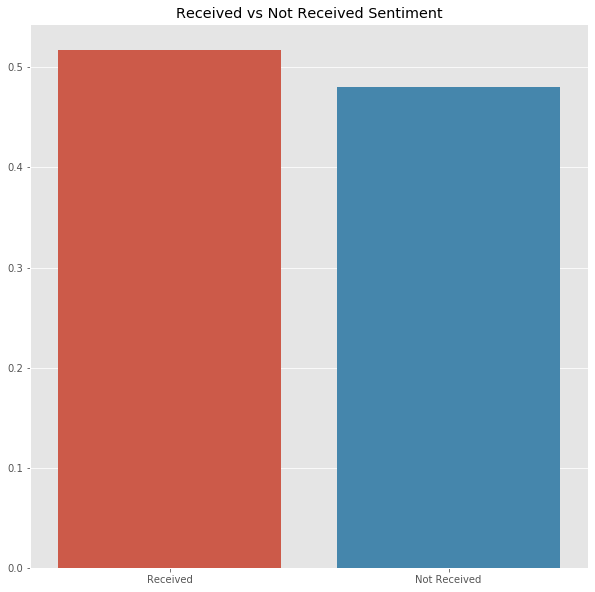

In [90]:
fig = plt.figure(figsize = (10,10))
plt.title('Received vs Not Received Sentiment')
sns.barplot(x = ['Received' , 'Not Received'], y = [np.mean(received['compound']),np.mean(not_received['compound']) ])

In [187]:
from datetime import datetime
combo_pizza_training['datetime'] = combo_pizza_training['unix_timestamp_of_request_utc'].apply(lambda x: pd.to_datetime(x))

In [189]:
combo_pizza_training.sort_values('datetime', ascending = True, inplace = True)

Posts that receive pizza has a higher sentiment value compared to posts that did not receive pizza: 0.52 vs 0.48.

## Length of Received Pizzas vs Not Received Pizzas

In [91]:
combo_pizza_training['len_of_posts'] = combo_pizza_training['request_text'].apply(lambda x: len(x))

In [92]:
combo_pizza_training

,request_text,received_pizza,unix_timestamp_of_request_utc,filtered_text,compound,len_of_posts
0,help me give back to my roomies on friday we'...,False,2012-07-11 00:21:35,roomie tampa florida ybor email major trouble ...,0.9675,1147
1,request colorado springs help us please hi i a...,False,2011-10-05 21:10:07,colorado springs child military family hit exa...,0.9518,356
2,"hungry couple in dundee, scotland would love ...",False,2011-10-26 16:28:14,hungry couple dundee scotland love girlfriend ...,0.9151,335
3,"in canada (ontario), just got home from schoo...",False,2011-12-02 19:50:34,ontario home school cold hungry completely hon...,0.5154,233
4,"california, no cash and i could use some dinn...",False,2012-03-25 04:13:44,california cash dinner spend money gas,-0.7845,123
...,...,...,...,...,...,...
30415,just got denied financial aid for college due ...,True,4/16/19 19:51,deny financial aid college absence mental heal...,-0.3842,405
30416,"broke and struggling, pls respond. hi raop! i...",False,1/11/14 12:05,struggle pls respond raop usually shot money p...,0.7273,437
30417,no desire to cook after a garbage day at work...,False,8/8/19 21:26,desire cook garbage work weird stressful work ...,0.8966,447
30418,hey there - i’m on week 7 of camping and i’m ...,True,8/21/19 20:02,camping peanut butter sandwich pay man mean re...,0.9737,631


In [93]:
combo_pizza_testing['len_of_posts'] = combo_pizza_testing['request_text'].apply(lambda x: len(x))

In [94]:
combo_pizza_testing

,request_text,unix_timestamp_of_request_utc,received_pizza,filtered_text,compound,len_of_posts
0,pregger gf 95 degree house and no food.. prom...,2011-06-24 23:56:59,False,pregger gf degree house pay northern colorado ...,0.8722,344
1,"lost my job day after labour day, start new j...",2013-09-15 15:45:23,False,lose job labour start job pay oct exist sick l...,-0.3067,657
2,just moved to a new state(waltham ma) all alo...,2013-07-30 20:38:02,False,ma comfort waltham ma home state pa comfort lo...,0.5922,205
3,(request) pizza for my kids please? hi reddit....,2011-10-14 22:53:41,False,kid single dad rough friend mention site work ...,0.9687,431
4,"two girls in between paychecks, we've all bee...",2012-05-02 03:52:38,False,paycheck indianapolis wish poptart pull double...,0.9692,488
...,...,...,...,...,...,...
8222,"my first day of vacation, would like a pizza ...",11/22/16 10:58,False,vacation play skyrim roommate house love munch...,0.9734,404
8223,my boyfriend and i would love something to ea...,6/29/15 14:21,False,boyfriend love raman instant potato illness mi...,0.7264,396
8224,"broke and hungry, would love some pizza title...",9/29/19 18:54,False,broke hungry love sum lol miss work couple inj...,0.9215,315
8225,a pizza for a toy store girl who does art in ...,9/30/14 23:01,False,toy store art spare nd work toy store ride bik...,0.9415,494


Received Pizza Submissions.

In [95]:
received['len_of_posts'] = received['request_text'].apply(lambda x: len(x))

/Users/rudywang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [96]:
received

,request_text,received_pizza,unix_timestamp_of_request_utc,filtered_text,compound,len_of_posts
5,i'll give a two week xbox live code for a sli...,True,2012-12-07 20:21:40,xbox code slice weather work hate beg payday c,0.4898,236
9,"we're in need of some om noms... austin, texas...",True,2011-08-31 20:59:42,om nom austin texas roommate hungry sort count...,0.7633,413
12,bummed out in chicago. too broke to go out on...,True,2013-01-19 01:34:46,bum chicago cheer unemployed work odd job work...,0.0880,400
15,"cookeville, tn. my dog recently died and i co...",True,2012-11-25 06:31:33,cookeville tn die cheer family pay later,0.4588,153
17,"virginia. girlfriend and i our sick, don't ge...",True,2012-09-11 18:41:38,virginia girlfriend sick pay love pay locate v...,0.7269,282
...,...,...,...,...,...,...
30373,family of 3 and a zoo od fur children on week...,True,12/1/17 20:31,family zoo od fur child power freshly flood ap...,0.0719,811
30391,trying to get the boys dinner it’s been a lon...,True,10/22/18 18:45,boy dinner fall old okay dwindle,-0.3937,289
30410,"broke, tired and the chickens frozen. hi all....",True,10/18/18 13:21,broke chicken freeze baby boy spend diaper wip...,0.8381,485
30415,just got denied financial aid for college due ...,True,4/16/19 19:51,deny financial aid college absence mental heal...,-0.3842,405


In [97]:
np.mean(received['len_of_posts'])

528.1311433664375

Not Received Pizza Submissions.

In [98]:
not_received['len_of_posts'] = not_received['request_text'].apply(lambda x: len(x))

/Users/rudywang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [99]:
np.mean(not_received['len_of_posts'])

434.4082587853395

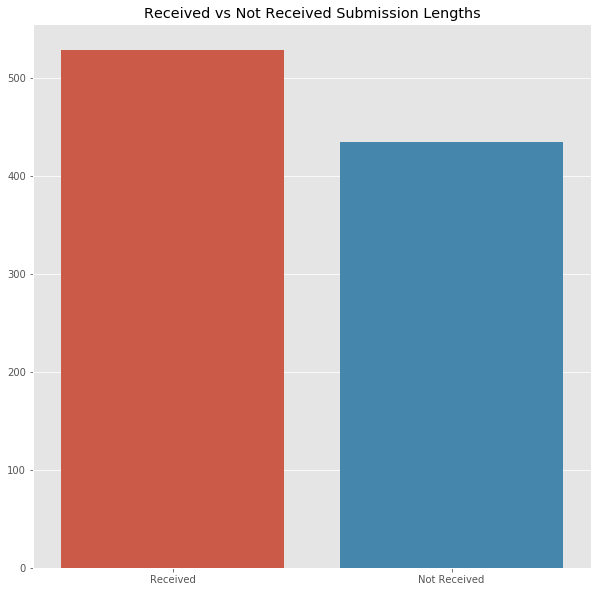

In [100]:
plt.figure(figsize = (10,10))
plt.title('Received vs Not Received Submission Lengths')
sns.barplot(x = ['Received', 'Not Received'], y = [np.mean(received['len_of_posts']), np.mean(not_received['len_of_posts'])]);

Posts that receive pizza has a longer text length compared to posts that did not receive pizza: 533 vs 434.

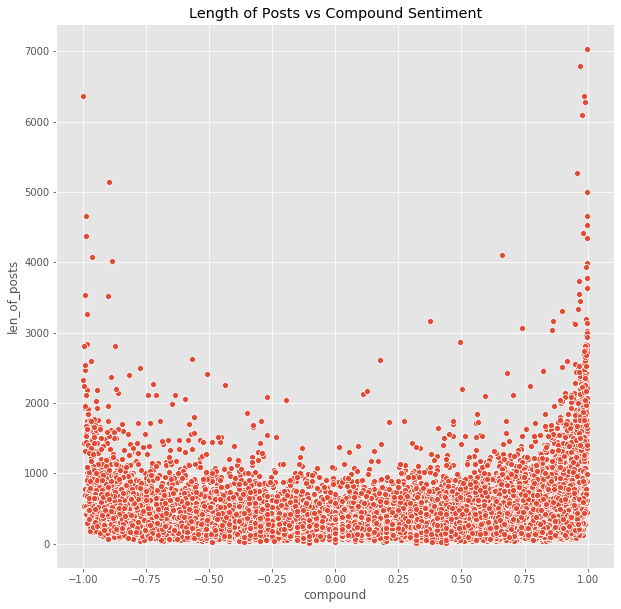

In [208]:
plt.figure(figsize = (10,10))
plt.title('Length of Posts vs Compound Sentiment')
sns.scatterplot(combo_pizza_training['compound'], combo_pizza_training['len_of_posts'])

In [202]:
combo_pizza_training

,request_text,received_pizza,unix_timestamp_of_request_utc,filtered_text,compound,len_of_posts,topic,datetime,month,year
380,no food / no money could use a pizza so im un...,False,2011-02-14 22:28:57,money unemployed brother town delay stay extra...,0.8196,460,0,2011-02-14 22:28:57,2011,2011
2304,working on projects all day and would love so...,True,2011-05-22 19:02:38,work project love za lock away zealously work ...,0.8016,230,0,2011-05-22 19:02:38,2011,2011
899,sick of chef boyardee... so my family has bee...,True,2011-05-23 20:29:10,sick chef boyardee family cent mortgage doubt ...,0.8555,358,0,2011-05-23 20:29:10,2011,2011
2739,really low on cash and ramen isn't so awesome ...,False,2011-05-23 21:08:22,low cash raman anymore reckon angel minimum wa...,-0.7172,280,2,2011-05-23 21:08:22,2011,2011
3977,just one more day! need help waiting it out h...,True,2011-05-24 17:23:41,protein shake cereal leftover gerbil income,0.9575,522,0,2011-05-24 17:23:41,2011,2011
...,...,...,...,...,...,...,...,...,...,...
8498,hey folks. i lost my job and then my fiancé l...,False,8/13/20 7:34,folk lose job fiancé country song broke halfwa...,-0.2023,203,3,2020-08-13 07:34:00,2020,2020
18109,been feeling depressed and could use a pick-m...,False,8/13/20 12:14,depressed quit job march mental toll worth pay...,-0.7037,489,3,2020-08-13 12:14:00,2020,2020
15088,finally had what feels like a good job interv...,False,8/13/20 12:35,job interview celebrate interview hopefully lo...,0.9016,349,3,2020-08-13 12:35:00,2020,2020
6311,"it’s been a long two weeks, my account is sup...",False,8/13/20 14:24,account overdrawn soften blow couple account o...,0.9822,589,2,2020-08-13 14:24:00,2020,2020


# Topic Modelling

## Count Vector NMF for Full Dataset

In [101]:
from sklearn.decomposition import NMF

In [102]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [103]:
nmf_model_full = NMF(4)

doc_topic_full = nmf_model_full.fit_transform(pizza_cv_training)

topic_word_full = pd.DataFrame(nmf_model_full.components_.round(3),
             index = ["component_1","component_2", "component_3", "component_4"],
             columns = cv_training.get_feature_names())

topic_word_full

,aa,ab,abandon,abc,ability,abit,abroad,abruptly,abscess,absence,...,zap,zealand,zelda,zero,zip,zipcode,zombie,zone,zoo,zza
component_1,0.001,0.004,0.007,0.000,0.013,0.001,0.004,0.004,0.001,0.007,...,0.002,0.003,0.003,0.031,0.011,0.000,0.005,0.004,0.004,0.008
component_2,0.000,0.004,0.000,0.000,0.000,0.001,0.000,0.002,0.001,0.001,...,0.000,0.003,0.000,0.022,0.018,0.001,0.000,0.007,0.000,0.001
component_3,0.002,0.001,0.000,0.000,0.003,0.000,0.000,0.004,0.000,0.010,...,0.000,0.000,0.000,0.005,0.010,0.001,0.000,0.006,0.000,0.000
component_4,0.007,0.002,0.013,0.001,0.049,0.001,0.014,0.000,0.000,0.002,...,0.004,0.010,0.002,0.046,0.021,0.005,0.003,0.001,0.003,0.003


In [104]:
display_topics(nmf_model_full, cv_training.get_feature_names(), 20)


Topic  0
work, home, love, car, start, people, dinner, family, lunch, sick, house, old, school, wife, hungry, couple, mom, cook, away, husband

Topic  1
pay, rent, account, paycheck, bank, hungry, check, broke, payday, raman, grocery, couple, cash, rice, card, car, love, roommate, gas, fridge

Topic  2
job, start, lose, paycheck, interview, celebrate, check, couple, rent, love, struggle, people, raman, unemployed, friend, let, school, quit, saving, unemployment

Topic  3
money, love, hungry, student, college, friend, home, family, spend, house, car, broke, account, dinner, bank, kid, card, people, mom, old


## Count Vector NMF Topic Modelling for Received vs Not Received Pizza (EDA)

We will first construct a NMF on the unigram words for received pizza.

In [105]:
nmf_model = NMF(4)

doc_topic = nmf_model.fit_transform(pizza_cv_received_uni)

topic_word = pd.DataFrame(nmf_model.components_.round(3),
             index = ["component_1","component_2", "component_3", "component_4"],
             columns = cv_received_uni.get_feature_names())
topic_word

,abandon,ability,absolute,absolutely,abuse,abusive,ac,accept,access,accident,...,young,youth,youtube,yr,yummy,za,zealand,zero,zip,zone
component_1,0.003,0.00,0.004,0.025,0.000,0.004,0.000,0.007,0.000,0.000,...,0.010,0.000,0.008,0.000,0.011,0.002,0.000,0.000,0.027,0.017
component_2,0.000,0.00,0.012,0.126,0.000,0.000,0.009,0.013,0.029,0.003,...,0.009,0.000,0.000,0.009,0.000,0.018,0.003,0.015,0.017,0.003
component_3,0.001,0.00,0.010,0.044,0.001,0.003,0.002,0.016,0.002,0.039,...,0.049,0.007,0.008,0.000,0.015,0.023,0.002,0.013,0.016,0.004
component_4,0.011,0.13,0.016,0.086,0.018,0.034,0.008,0.066,0.069,0.121,...,0.107,0.004,0.015,0.009,0.005,0.034,0.015,0.026,0.013,0.002


We constructed a function that will give us the top topics within each NMF model.

In [106]:
display_topics(nmf_model, cv_received_uni.get_feature_names(), 20)


Topic  0
job, start, lose, interview, paycheck, love, couple, celebrate, unemployed, struggle, school, check, people, unemployment, enjoy, spend, let, partner, apartment, rent

Topic  1
pay, bill, rent, love, paycheck, account, car, check, raman, hungry, bank, payday, broke, grocery, gas, cash, couple, start, house, rice

Topic  2
work, home, love, husband, wife, family, hungry, car, dinner, kid, lunch, school, couple, paycheck, people, old, start, house, hospital, deal

Topic  3
money, student, hungry, college, account, friend, spend, car, family, card, love, broke, home, kid, bill, bank, house, old, mom, dinner


It's quite clear that the bi-gram's NMF model did not produce as great topics as the uni-gram NMF model. So for received pizza submissions, we will go with the NMF model with 4 topics with the count vectorizer.

Now, let's go ahead and check out how the CV-NMF model handles topic modelling for no pizza received submissions.

In [107]:
nmf_model_2 = NMF(4)

doc_topic_2 = nmf_model_2.fit_transform(pizza_cv_not_received_uni)

topic_word_2 = pd.DataFrame(nmf_model_2.components_.round(3),
             index = ["component_1","component_2", "component_3", "component_4"],
             columns = cv_not_received_uni.get_feature_names())
topic_word_2

,aa,ab,abandon,abc,ability,abroad,abruptly,abscess,absence,absent,...,zap,zealand,zelda,zero,zip,zipcode,zombie,zone,zoo,zza
component_1,0.003,0.004,0.007,0.000,0.021,0.004,0.004,0.001,0.006,0.002,...,0.002,0.002,0.002,0.031,0.007,0.000,0.005,0.003,0.004,0.007
component_2,0.000,0.004,0.000,0.000,0.000,0.000,0.003,0.002,0.000,0.001,...,0.001,0.003,0.000,0.021,0.016,0.001,0.000,0.007,0.000,0.001
component_3,0.000,0.001,0.000,0.001,0.004,0.000,0.002,0.000,0.008,0.006,...,0.000,0.000,0.000,0.007,0.005,0.001,0.000,0.003,0.000,0.000
component_4,0.005,0.002,0.011,0.001,0.023,0.016,0.000,0.000,0.002,0.000,...,0.005,0.007,0.001,0.044,0.018,0.004,0.003,0.000,0.003,0.001


In [108]:
display_topics(nmf_model_2, cv_not_received_uni.get_feature_names(), 20)


Topic  0
work, home, love, car, start, people, dinner, lunch, sick, family, house, old, school, hungry, couple, wife, away, cook, mom, mean

Topic  1
pay, bill, rent, account, paycheck, bank, check, hungry, broke, payday, raman, grocery, couple, card, rice, cash, roommate, fridge, grateful, car

Topic  2
job, start, lose, paycheck, interview, celebrate, check, rent, couple, struggle, raman, love, people, friend, unemployed, let, school, quit, hire, saving

Topic  3
money, love, hungry, student, college, friend, home, family, spend, house, car, broke, dinner, account, bank, kid, people, card, mom, couple


## TF-IDF NMF Topic Modelling

We'll first take a look at the full training dataset topics.

In [109]:
nmf_model_tfidf_full = NMF(4, max_iter = 1000)

doc_topic_tfidf_full = nmf_model_tfidf_full.fit_transform(tfidf_train_vector)

display_topics(nmf_model_tfidf_full, tfidf_all_train.get_feature_names(), 20)


Topic  0
work, love, money, home, family, dinner, friend, house, birthday, kid, car, mom, spend, wife, sick, old, surprise, lunch, people, couple

Topic  1
hungry, student, college, broke, money, final, study, sob, school, raman, starve, semester, class, loan, university, exam, account, kid, crave, grateful

Topic  2
pay, rent, bill, money, account, payday, paycheck, bank, check, raman, grocery, fridge, couple, rice, gas, cash, car, roommate, deposit, grateful

Topic  3
job, start, lose, paycheck, celebrate, interview, check, work, couple, unemployed, raman, struggle, search, unemployment, rent, fire, money, hire, land, rough


In [110]:
doc_topic_tfidf_test = nmf_model_tfidf_full.transform(tfidf_test_vector) # Testing

In [111]:
combo_pizza_training['topic'] = doc_topic_tfidf_full.argmax(axis =1)

In [112]:
combo_pizza_training

,request_text,received_pizza,unix_timestamp_of_request_utc,filtered_text,compound,len_of_posts,topic
0,help me give back to my roomies on friday we'...,False,2012-07-11 00:21:35,roomie tampa florida ybor email major trouble ...,0.9675,1147,2
1,request colorado springs help us please hi i a...,False,2011-10-05 21:10:07,colorado springs child military family hit exa...,0.9518,356,0
2,"hungry couple in dundee, scotland would love ...",False,2011-10-26 16:28:14,hungry couple dundee scotland love girlfriend ...,0.9151,335,0
3,"in canada (ontario), just got home from schoo...",False,2011-12-02 19:50:34,ontario home school cold hungry completely hon...,0.5154,233,1
4,"california, no cash and i could use some dinn...",False,2012-03-25 04:13:44,california cash dinner spend money gas,-0.7845,123,0
...,...,...,...,...,...,...,...
30415,just got denied financial aid for college due ...,True,4/16/19 19:51,deny financial aid college absence mental heal...,-0.3842,405,1
30416,"broke and struggling, pls respond. hi raop! i...",False,1/11/14 12:05,struggle pls respond raop usually shot money p...,0.7273,437,2
30417,no desire to cook after a garbage day at work...,False,8/8/19 21:26,desire cook garbage work weird stressful work ...,0.8966,447,2
30418,hey there - i’m on week 7 of camping and i’m ...,True,8/21/19 20:02,camping peanut butter sandwich pay man mean re...,0.9737,631,1


For our full training dataset, we identified the topics to be:

Topic 0: Family

Topic 1: Homeless

Topic 2: Money

Topic 3: Unemployment

Topic 4: Student

Let's create a new DataFrame that will have hold our independent variables to train for our target variable.

Our X matrix will have the compound (sentiment), length of posts, and the 5 topics as features for our logistic regression.

Our target variable will be received_pizza - we will predict whether a post submission is True or False in terms of getting a pizza.

In [113]:
X_training_dataset = combo_pizza_training[['compound', 'len_of_posts']]

In [114]:
final_training_topics = pd.DataFrame(doc_topic_tfidf_full)

final_training_topics.columns = ['family', 'student', 'money', 'unemployment']


In [115]:
X_training_dataset = pd.concat([X_training_dataset, final_training_topics], axis = 1)

In [116]:
X_training_dataset

,compound,len_of_posts,family,student,money,unemployment
0,0.9675,1147,0.018486,0.000000,0.041884,0.015433
1,0.9518,356,0.020747,0.000000,0.000000,0.000000
2,0.9151,335,0.029136,0.025235,0.002227,0.000542
3,0.5154,233,0.020449,0.045323,0.000000,0.000000
4,-0.7845,123,0.040708,0.005568,0.008886,0.000000
...,...,...,...,...,...,...
30415,-0.3842,405,0.022289,0.025550,0.000000,0.021582
30416,0.7273,437,0.035645,0.005664,0.060208,0.000730
30417,0.8966,447,0.019732,0.000000,0.037841,0.025764
30418,0.9737,631,0.008777,0.019905,0.018563,0.011597


In [117]:
y_train_dataset = combo_pizza_training['received_pizza']

In [118]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, f1_score, plot_confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

In [119]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_training_dataset)

In [120]:
model = []
logreg = LogisticRegression(class_weight = {0: 1, 1: 8})
model.append(logreg)

knn = KNeighborsClassifier()
model.append(knn)

gmb = GaussianNB()
model.append(gmb)

svc = SVC(class_weight={0: 1, 1: 8})
model.append(svc)

dtc = DecisionTreeClassifier(class_weight={0: 1, 1: 8})#, max_depth=3,min_samples_leaf=0.1, min_samples_split=0.1)
model.append(dtc)

rfc = RandomForestClassifier(class_weight={0: 1, 1: 8})
model.append(rfc)

In [121]:
from collections import defaultdict

In [122]:
baseline_dict = defaultdict(list)
for each in model:
    scores = cross_validate(each, X_train_scaled, y_train_dataset, cv = 10, scoring = ['accuracy','f1', 'precision'])
    baseline_dict[str(each)]
    y_pred = each.predict
    for score in scores:
        if score == 'fit_time' or score == 'score_time':
            continue
        else:
            baseline_dict[str(each)].append(f'{score}: {np.mean(scores[score]): .4f}')

In [123]:
baseline_dict

defaultdict(list,
            {'LogisticRegression(class_weight={0: 1, 1: 8})': ['test_accuracy:  0.4401',
              'test_f1:  0.2551',
              'test_precision:  0.1540'],
             'KNeighborsClassifier()': ['test_accuracy:  0.8552',
              'test_f1:  0.0460',
              'test_precision:  0.1566'],
             'GaussianNB()': ['test_accuracy:  0.8609',
              'test_f1:  0.0504',
              'test_precision:  0.2184'],
             'SVC(class_weight={0: 1, 1: 8})': ['test_accuracy:  0.4328',
              'test_f1:  0.2536',
              'test_precision:  0.1528'],
             'DecisionTreeClassifier(class_weight={0: 1, 1: 8})': ['test_accuracy:  0.7843',
              'test_f1:  0.1522',
              'test_precision:  0.1546'],
             'RandomForestClassifier(class_weight={0: 1, 1: 8})': ['test_accuracy:  0.8702',
              'test_f1:  0.0010',
              'test_precision:  0.1250']})

The model with the highest training accuracy score is the RandomForestClassifier with an accuracy score of 87%. 

Let's apply it to our testing dataset and see the results.

In [124]:
X_testing_dataset = combo_pizza_testing[['compound', 'len_of_posts']]

In [125]:
final_testing_topics = pd.DataFrame(doc_topic_tfidf_test)

In [126]:
X_testing_dataset = pd.concat([X_testing_dataset, final_testing_topics], axis = 1)

In [127]:
X_testing_dataset.head()

,compound,len_of_posts,0,1,2,3
0,0.8722,344,0.015371,0.002198,0.049124,0.000000
1,-0.3067,657,0.003379,0.000000,0.082866,0.072549
2,0.5922,205,0.012023,0.001145,0.000000,0.000663
3,0.9687,431,0.030372,0.000000,0.023548,0.028022
4,0.9692,488,0.015396,0.000166,0.021534,0.004462


In [128]:
X_test_scaled = scaler.transform(X_testing_dataset)

In [129]:
y_test_dataset = combo_pizza_testing['received_pizza']

In [130]:
rfc_test = RandomForestClassifier(class_weight={0: 1, 1: 8})

rfc_test.fit(X_train_scaled, y_train_dataset)

RandomForestClassifier(class_weight={0: 1, 1: 8})

In [131]:
_ = cross_validate(rfc_test, X_test_scaled, y_test_dataset, cv = 10, scoring = 'accuracy')

In [132]:
rfc_test_scores = []
for score in _:
    rfc_test_scores.append(f'{score}: {np.mean(_[score]): .4f}')   

In [133]:
rfc_test_scores

['fit_time:  1.1170', 'score_time:  0.0193', 'test_score:  0.9098']

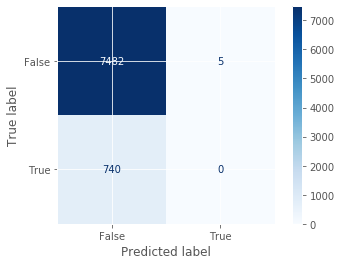

In [134]:
plot_confusion_matrix(rfc_test.fit(X_train_scaled, y_train_dataset), X_test_scaled, y_test_dataset, cmap = plt.cm.Blues)

In [135]:
knn_test = KNeighborsClassifier()

knn_test.fit(X_train_scaled, y_train_dataset)

KNeighborsClassifier()

In [136]:
_ = cross_validate(knn_test, X_test_scaled, y_test_dataset, cv = 10, scoring = 'accuracy')

In [137]:
knn_test_scores = []
for score in _:
    knn_test_scores.append(f'{score}: {np.mean(_[score]): .4f}')   

In [138]:
knn_test_scores

['fit_time:  0.0053', 'score_time:  0.0419', 'test_score:  0.9041']

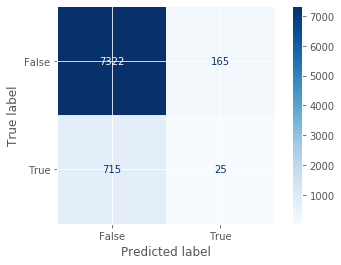

In [139]:
plot_confusion_matrix(knn_test.fit(X_train_scaled, y_train_dataset), X_test_scaled, y_test_dataset, cmap = plt.cm.Blues)

## TF-IDF NMF Topic Modelling for Received vs Not Received Pizza (EDA)

We'll also take a look at received vs not received pizza submissions using the TF-IDF sparse matrix with the NMF model to see if we could receive better, different topics.

In [140]:
nmf_model_tfidf = NMF(5, max_iter = 1000)

doc_topic_tfidf = nmf_model_tfidf.fit_transform(tfidf_vector_received)

display_topics(nmf_model_tfidf, tfidf.get_feature_names(), 20)


Topic  0
work, money, home, family, car, dinner, kid, wife, mom, husband, old, house, friend, spend, tight, sick, lunch, stay, people, hospital

Topic  1
job, start, lose, paycheck, interview, couple, check, unemployed, celebrate, unemployment, money, rough, struggle, search, quit, low, mean, land, saving, graduate

Topic  2
pay, hungry, account, rent, payday, paycheck, bank, raman, money, house, check, grocery, fridge, car, gas, broke, rice, cash, negative, repair

Topic  3
student, college, broke, hungry, money, final, raman, study, school, loan, semester, summer, exam, finish, rice, spend, campus, class, rent, financial

Topic  4
love, celebrate, birthday, surprise, kid, dinner, wife, treat, delicious, mom, daughter, payday, sick, old, amazing, raman, smile, starve, cash, cook


In [141]:
received_doc_topic = pd.DataFrame(doc_topic_tfidf)

# Let's go ahead and rename the columns in our DataFrame as well.

received_doc_topic.columns = ['family', 'unemployment', 'money', 'student', 'favors_treats']

received_doc_topic.head()

,family,unemployment,money,student,favors_treats
0,0.042428,0.000000,0.014728,0.000000,0.001044
1,0.022296,0.005735,0.016646,0.023462,0.006319
2,0.054042,0.090689,0.066767,0.000000,0.000000
3,0.022272,0.000000,0.062326,0.000000,0.000114
4,0.000000,0.000000,0.128105,0.000000,0.076898


In [144]:
nmf_model_tfidf2 = NMF(5, max_iter = 1000)

doc_topic_tfidf2 = nmf_model_tfidf2.fit_transform(tfidf_vector_not_received)

display_topics(nmf_model_tfidf2, tfidf2.get_feature_names(), 20)


Topic  0
love, work, money, home, friend, family, dinner, house, birthday, car, spend, kid, mom, wife, sick, old, surprise, couple, lunch, people

Topic  1
hungry, broke, sob, money, house, crave, payday, fridge, homeless, cash, grateful, starve, pantry, check, unemployed, couple, pregnant, paycheck, generous, wanna

Topic  2
pay, rent, money, payday, account, paycheck, bank, check, raman, grocery, couple, cash, rice, fridge, broke, gas, roommate, deposit, car, low

Topic  3
job, start, lose, paycheck, celebrate, interview, check, work, raman, couple, unemployed, struggle, rent, search, unemployment, hire, money, land, saving, quit

Topic  4
student, college, broke, final, study, money, school, semester, loan, university, exam, class, kid, raman, finish, starve, summer, campus, account, graduate


In [145]:
not_received_doc_topic = pd.DataFrame(doc_topic_tfidf2)

not_received_doc_topic.columns = ['family', 'homeless', 'money', 'unemployment', 'student']

not_received_doc_topic.head()

,family,homeless,money,unemployment,student
0,0.019569,0.000000,0.046330,0.017315,0.000000
1,0.019883,0.000000,0.000000,0.000000,0.000000
2,0.032735,0.033687,0.002994,0.000581,0.000000
3,0.020573,0.042401,0.000000,0.000000,0.016925
4,0.041336,0.002662,0.008923,0.000000,0.002965


There is a difference in topics between submissions that receive pizza and posts that do not receive pizza.

In [146]:
received['topic'] = received_doc_topic.to_numpy().argmax(axis =1)

/Users/rudywang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [147]:
plot_values = received['topic'].value_counts()

In [148]:
plot_values

0    1268
2     879
1     625
3     604
4     551
Name: topic, dtype: int64

In [149]:
# Let's go ahead and replace the numbers with the actual topics associated with each number so we can make better plots.

received['topic'] = received['topic'].astype(str).str.replace('0', 'Family')
received['topic'] = received['topic'].astype(str).str.replace('1', 'Student')
received['topic'] = received['topic'].astype(str).str.replace('2', 'Money')
received['topic'] = received['topic'].astype(str).str.replace('3', 'Unemployment')
received['topic'] = received['topic'].astype(str).str.replace('4', 'Favors + Specials')

/Users/rudywang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/rudywang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/rudywang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set 

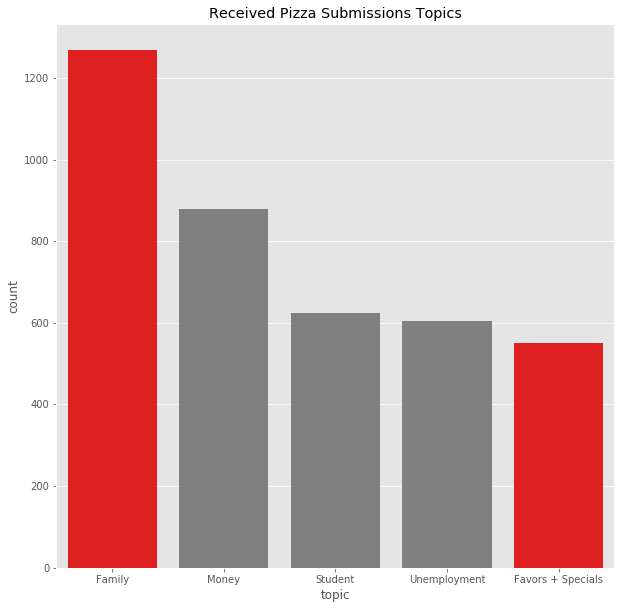

In [156]:
plt.figure(figsize = (10,10))
plt.title('Received Pizza Submissions Topics')
clrs = ['grey' if (580 < x < 1100) else 'red' for x in plot_values]
sns.countplot(received['topic'], order = ['Family',  'Money','Student', 'Unemployment', 'Favors + Specials'], palette = clrs)

In [151]:
not_received['topic'] = not_received_doc_topic.to_numpy().argmax(axis =1)

/Users/rudywang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [152]:
plot_values2 = not_received['topic'].value_counts()

In [153]:
plot_values2

0    11919
2     4757
3     3585
4     3251
1     2981
Name: topic, dtype: int64

In [154]:
not_received['topic'] = not_received['topic'].astype(str).str.replace('0', 'Family')
not_received['topic'] = not_received['topic'].astype(str).str.replace('1', 'Homeless')
not_received['topic'] = not_received['topic'].astype(str).str.replace('2', 'Money')
not_received['topic'] = not_received['topic'].astype(str).str.replace('3', 'Unemployment')
not_received['topic'] = not_received['topic'].astype(str).str.replace('4', 'Student')

/Users/rudywang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/rudywang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/rudywang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

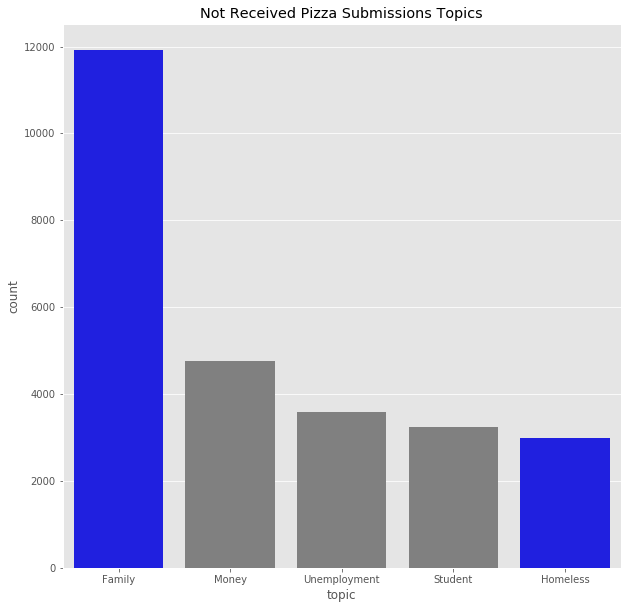

In [161]:
plt.figure(figsize = (10,10))
plt.title('Not Received Pizza Submissions Topics')
clrs = ['grey' if (3000 < x < 10000) else 'blue' for x in plot_values2]
sns.countplot(not_received['topic'], order = ['Family', 'Money', 'Unemployment', 'Student', 'Homeless'], palette = clrs)